In [1]:
%pylab inline
import torch
import numpy
import sklearn.datasets
import torchvision.datasets
import os
from scipy.misc import imresize as imgresize
from pycocotools import coco

torch.manual_seed(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_dest = "../../val2017"
target_dest = "../../annotations/instances_val2017_people.json"

In [3]:
# import json 
# spooky scary preprocessing
# with open("../../annotations/instances_val2017.json") as rfile, open("../../annotations/instances_val2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

# with open("../../annotations/instances_train2017.json") as rfile, open("../../annotations/instances_train2017_people.json", 'w') as wfile:
#     data = json.load(rfile)
#     data["annotations"] = list(filter(lambda x: x["category_id"] == 1, data["annotations"]))
#     json.dump(data, wfile)

In [4]:
COCO = coco.COCO(target_dest)

def toMask(x):
    return np.sum(COCO.annToMask(i) > 0 for i in x)

def resizeNP(x):
    if type(x) == int and x == 0:
        return np.zeros((320, 320))
    return (imgresize(x, (320, 320), 'bilinear') > 0).astype(int)
    
def toTensor(x):
    return torch.from_numpy(x).float().unsqueeze(0)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [9]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((320, 320)), #реобразует картинку к указанному размеру
         torchvision.transforms.ToTensor()                   # Переводит объект "картинка" к torch.Tensor
    ])

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Lambda(toMask),
        torchvision.transforms.Lambda(resizeNP),
        torchvision.transforms.Lambda(toTensor),        
    ])

In [10]:
dataset = torchvision.datasets.CocoDetection(train_dest, target_dest, transform=transforms,
                                              target_transform=train_transforms)

data_loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    batch_size=16,
    num_workers=4)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [11]:
dataset[3][0]

tensor([[[ 0.3529,  0.3569,  0.3490,  ...,  0.7294,  0.7294,  0.7294],
         [ 0.3529,  0.3490,  0.3490,  ...,  0.7373,  0.7255,  0.7176],
         [ 0.3490,  0.3569,  0.3569,  ...,  0.7412,  0.7294,  0.7216],
         ...,
         [ 0.3765,  0.3843,  0.3843,  ...,  0.7373,  0.7255,  0.7098],
         [ 0.3804,  0.3922,  0.3882,  ...,  0.7255,  0.7216,  0.7137],
         [ 0.3804,  0.3882,  0.3882,  ...,  0.7255,  0.7176,  0.7137]],

        [[ 0.3333,  0.3412,  0.3373,  ...,  0.7373,  0.7373,  0.7373],
         [ 0.3412,  0.3333,  0.3333,  ...,  0.7412,  0.7333,  0.7255],
         [ 0.3373,  0.3373,  0.3373,  ...,  0.7490,  0.7373,  0.7294],
         ...,
         [ 0.3373,  0.3451,  0.3451,  ...,  0.7255,  0.7216,  0.7059],
         [ 0.3412,  0.3490,  0.3490,  ...,  0.7137,  0.7137,  0.7098],
         [ 0.3333,  0.3490,  0.3490,  ...,  0.7098,  0.7098,  0.7098]],

        [[ 0.2745,  0.2980,  0.2980,  ...,  0.7176,  0.7216,  0.7255],
         [ 0.2824,  0.2902,  0.2980,  ...,  0

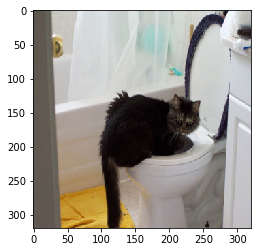

In [12]:
plt.imshow(dataset[3][0].numpy().swapaxes(0,1).swapaxes(1,2))
plt.show()

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [14]:
class UNetConvBlock(torch.nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size=7, padding=3, activation=torch.nn.ReLU, pooling=True):
        super(UNetConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_layers, out_layers, kernel_size, padding=padding)
        self.bnorm1 = torch.nn.BatchNorm2d(out_layers)
        self.conv2 = torch.nn.Conv2d(out_layers, out_layers, kernel_size, padding=padding)
        self.bnorm2 = torch.nn.BatchNorm2d(out_layers)
        self.pooling = pooling
        self.pool = torch.nn.MaxPool2d(2)
        self.activation = activation()
        
    def forward(self, x):
        out = self.activation(self.conv(x))
        out = self.bnorm1(out)
        out = self.activation(self.conv2(out))
        out = self.bnorm2(out)
        if (self.pooling):
            out = self.pool(out)
        return out     
    
class UNetUpConvBlock(torch.nn.Module):
    def __init__(self, in_layers, out_layers, kernel_size=3, padding=1, activation=torch.nn.ReLU):
        super(UNetUpConvBlock, self).__init__()
        self.upconv = torch.nn.Conv2d(in_layers, 4*in_layers, 1)
        self.pixelshuffle = torch.nn.PixelShuffle(2)
        self.conv = UNetConvBlock(in_layers, out_layers, pooling=False)  
        
    def forward(self, x):
        out = self.upconv(x)
        out = self.pixelshuffle(out)
        out = self.conv(out)
        return out    

def stack(old, new):
    return torch.cat([old, new], dim=1)

In [15]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.conv1 = UNetConvBlock(3, 16)
        self.conv2 = UNetConvBlock(16, 32)
        self.conv3 = UNetConvBlock(32, 64)

        self.upconv3 = UNetUpConvBlock(64, 32) # 64 -> 32
        self.upconv2 = UNetUpConvBlock(64, 16)  # stack with conv2 32 + 32 -> 16
        self.upconv1 = UNetUpConvBlock(32, 8) # stack with conv1 16 + 16 -> 8
        
        self.fullconv = torch.nn.Conv2d(11, 1, 1) # with initial 8 + 3 -> 1 
        self.pred = torch.nn.Sigmoid()
        
    def forward(self, x):
        initial = x.clone()
        
        c1 = self.conv1(x)
        c2 = self.conv2(c1)          
        x = self.conv3(c2)
        
        x = self.upconv3(x)
        
        x = stack(c2, x)
        x = self.upconv2(x)
        
        x = stack(c1, x)
        x = self.upconv1(x)
        
        x = stack(initial, x)
        x = self.fullconv(x)  
        x = self.pred(x)
        return x

In [16]:
net = UNet().to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

if os.path.exists("state_dict.wght"):
    net.load_state_dict(torch.load("state_dict.wght"))

In [17]:
from sklearn.metrics import jaccard_similarity_score

# def intersection_over_union(pred, target):
#     pred = pred > 0.5
#     target = target > 0
#     intersection = (pred * target > 0).sum().item()
#     union = (pred + target > 0).sum().item() 
#     return intersection / union

# metric = intersection_over_union
# batch_labels.shape
# metric(np.ones((1, 320,320)), np.ones((1, 320,320)))

def iou(d):
    pred, target = d
    pred = pred.squeeze(0) > 0.5
    target = target.squeeze(0) > 0
    return jaccard_similarity_score(pred, target)
def mean_iou(pred, target):
    ious = list(map(iou, list(zip(pred, target))))
    return sum(ious) / len(ious)

metric = mean_iou

In [18]:
errs, metrics = list(), list()
for epoch in range(2):
    print("Epoch {} started".format(epoch))
    order = random.permutation(len(dataset.ids))
    net.train()
    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        
        batch_features = data.to(device)
        batch_labels = target.to(device)
        
        batch_preds = net.forward(batch_features)

        loss = criterion(batch_preds, batch_labels)
        loss.backward()
        optimizer.step()
        
        if i % 25 == 0:
            err = loss.item()
            metric = mean_iou(batch_preds.cpu().data.numpy(),batch_labels.cpu().data.numpy())
            errs.append(err)
            metrics.append(metric)
            print("Batch {} loss {}, ".format(i, err), end="")
            print("intersection over union: {}".format(metric))

Epoch 0 started
Batch 0 loss 0.12713444232940674, intersection over union: 0.8279109089097723
Batch 25 loss 0.27659159898757935, intersection over union: 0.7157186778525875
Batch 50 loss 0.1233082264661789, intersection over union: 0.7704330102245185
Batch 75 loss 0.1003003716468811, intersection over union: 0.7448532957203203
Batch 100 loss 0.08673490583896637, intersection over union: 0.868778162175222
Batch 125 loss 0.14549385011196136, intersection over union: 0.7900758165490649
Batch 150 loss 0.06739185005426407, intersection over union: 0.8716328031877114
Batch 175 loss 0.07089618593454361, intersection over union: 0.851666151374971
Batch 200 loss 0.06761515885591507, intersection over union: 0.836843777777827
Batch 225 loss 0.1088290810585022, intersection over union: 0.7353222912437527
Batch 250 loss 0.16950689256191254, intersection over union: 0.7742399833214701
Batch 275 loss 0.11746171861886978, intersection over union: 0.8092784451157062
Batch 300 loss 0.1090526282787323, 

In [19]:
def showimgs(data_loader, net, batches=1):
    for i, (data, target) in enumerate(data_loader):
        pred = net.forward(data.to(device))
        for img_data, border_data, pred_data in zip(data, target, pred):
            fig, (img, border, prediction) = plt.subplots(1, 3)
            img.imshow(img_data.numpy().swapaxes(0,1).swapaxes(1,2))
            border.imshow(border_data.numpy().squeeze(0))
            prediction.imshow(pred_data.cpu().data.numpy().squeeze(0))
            plt.show()
        if (i == batches):
            break
        
def showpred(pred):
    for i in pred:
        plt.imshow(i.numpy().squeeze(0))
        plt.show()

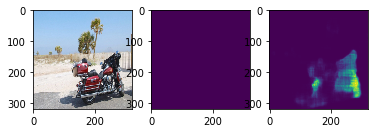

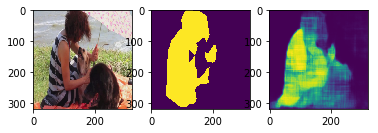

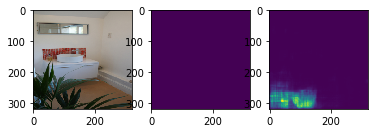

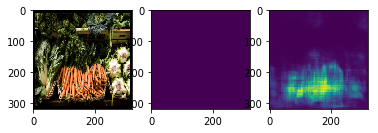

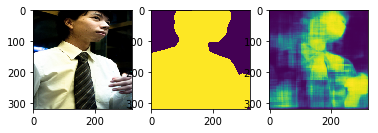

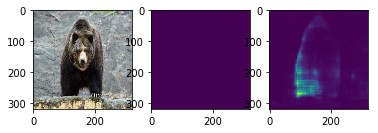

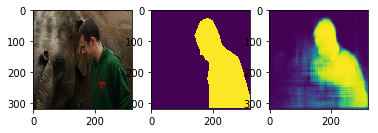

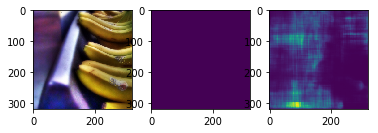

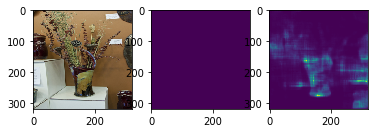

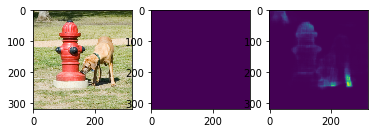

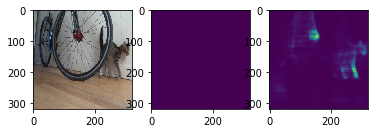

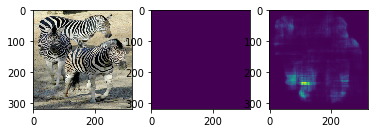

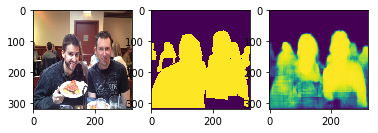

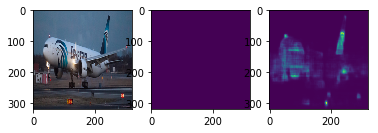

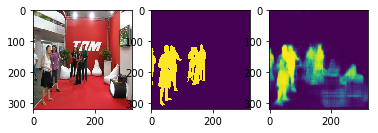

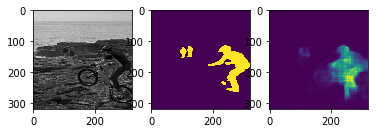

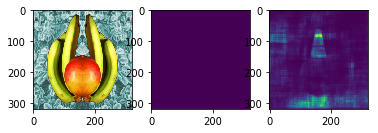

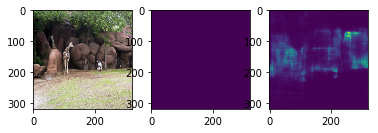

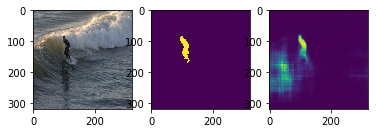

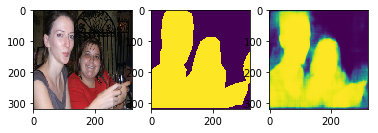

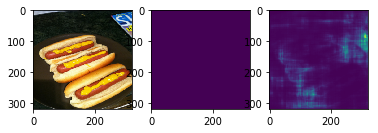

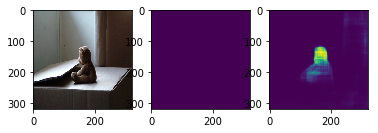

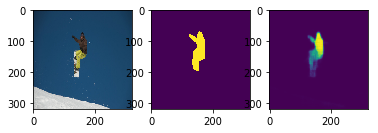

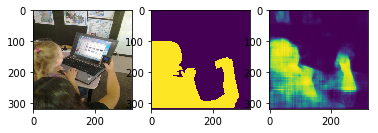

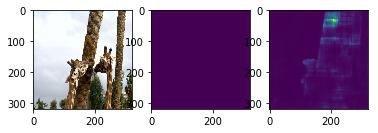

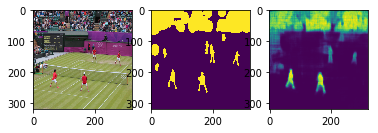

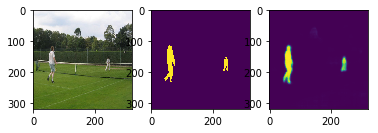

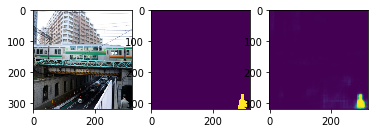

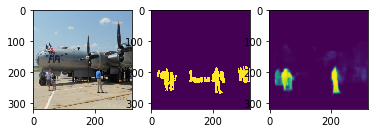

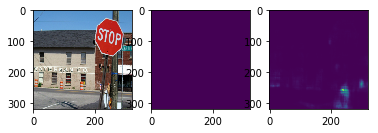

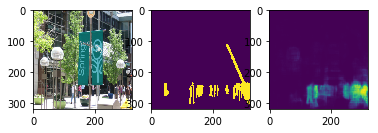

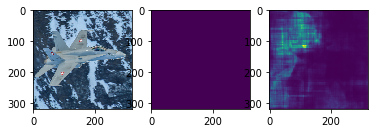

In [20]:
showimgs(data_loader, net, batches=1)

In [ ]:
torch.save(net.state_dict(), "state_dict.wght")

In [ ]:
max(errs), min(errs)